In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import warnings
import tensorflow as tf
from keras import backend as K
from keras.models import Model,Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")

In [2]:
def split_array_by_index(arr,index):
    if index<0:
        raise ValueError("split_index out of bounds")
    return arr[0:index],arr[index:]

In [3]:
alphabets_images_dataset_raw = pd.read_csv(r"C:\Users\tanay\OneDrive\Documents\Work\Epoch\Epoch Repository\Databases Used\alphabets_28x28.csv")

In [4]:
print(alphabets_images_dataset_raw.shape[0],alphabets_images_dataset_raw.shape[1])
alphabets_images_dataset_raw.head()

372451 785


,label,row 1 col 1 pixel,row 1 col 2 pixel,row 1 col 3 pixel,row 1 col 4 pixel,row 1 col 5 pixel,row 1 col 6 pixel,row 1 col 7 pixel,row 1 col 8 pixel,row 1 col 9 pixel,...,row 28 col 19 pixel,row 28 col 20 pixel,row 28 col 21 pixel,row 28 col 22 pixel,row 28 col 23 pixel,row 28 col 24 pixel,row 28 col 25 pixel,row 28 col 26 pixel,row 28 col 27 pixel,row 28 col 28 pixel
0,A,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
alphabets_images_dataset_raw.dropna(axis=0,inplace=True)
alphabets_images_dataset= alphabets_images_dataset_raw.drop_duplicates()

In [6]:
print(alphabets_images_dataset.shape)

(217581, 785)


Extraction from CSV

In [7]:
def convert_csv_data_to_dataset(alphabets_images_dataset):

    labels,images=[],[]
    for iter_ in range(alphabets_images_dataset.shape[0]):
        target,img_array = split_array_by_index(alphabets_images_dataset.iloc[iter_].values,1)
        img_array = img_array.astype(int)
        img = img_array.reshape(28,28,1)
        images.append(img)
        labels.append(target[0])

    images = np.array(images)
    labels = np.array(labels)

    print(f'img dataset shape:{images.shape}')
    print(f'labels shape:{labels.shape}')
    
    return images,labels

In [8]:
images,labels = convert_csv_data_to_dataset(alphabets_images_dataset) 

img dataset shape:(217581, 28, 28, 1)
labels shape:(217581,)


In [9]:
np.unique(labels)

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype='<U1')

Splitting into training and testing data

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=3,test_size=0.2, random_state=42)
split.get_n_splits(images,labels)
print(split)

StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.2,
            train_size=None)


In [11]:
for i, (train_index, test_index) in enumerate(split.split(images,labels)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 16164  54141  38270 ... 184191  95069  62853]
  Test:  index=[128761  95521  87566 ... 184017 202843  59026]
Fold 1:
  Train: index=[ 96335 150508 164397 ... 151247  39834  49804]
  Test:  index=[ 56350   1735 180491 ...  56832 132641 149164]
Fold 2:
  Train: index=[  4428 191748 164740 ... 143165 124399 113354]
  Test:  index=[141034  36922  29955 ...  53758  59277  26051]


In [12]:
train_images = images[train_index]
train_labels = labels[train_index]

test_images = images[test_index]
test_labels = labels[test_index]

In [13]:
len(np.unique(train_labels)),len(np.unique(test_labels))

(26, 26)

Encoding Categorical Data

In [14]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

encoder = OneHotEncoder()

train_labels_enc = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_enc = encoder.transform(test_labels.reshape(-1, 1)).toarray()

In [15]:
train_labels_enc.shape,test_labels_enc.shape

((174064, 26), (43517, 26))

Model Architecture

In [65]:
num_classes = 26

model = Sequential()
# Resise data within the neural network
# CNN model - Building the model suggested in paper

model.add(Conv2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', input_shape= (28,28,1), name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Conv2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Flatten())

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 14, 14, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 26)             │        15,002 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 26)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,330 (134.10 KB)

 Trainable params: 34,330 (134.10 KB)

 Non-trainable params: 0 (0.00 B)

None


In [66]:
model.fit(train_images,train_labels_enc,epochs=10,batch_size=32)

Epoch 1/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8595 - loss: 0.8991
Epoch 2/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9653 - loss: 0.1253
Epoch 3/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9688 - loss: 0.1126
Epoch 4/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9714 - loss: 0.1027
Epoch 5/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9729 - loss: 0.0980
Epoch 6/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9742 - loss: 0.0940
Epoch 7/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9740 - loss: 0.0928
Epoch 8/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9743 - loss: 0.0967
Epoch 9/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9762 - loss: 0.0872
Epoch 10/10
5440/5440 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9759 - loss: 0.0911


In [67]:
model.evaluate(test_images,test_labels_enc)

1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9683 - loss: 0.1389


[0.13679224252700806, 0.969598114490509]

In [68]:
model.save('cnn_model_for_images_test.keras')

Processing Trager Images

In [69]:
target_imgs_dir = 'target_images'
target_imgs = []
import os
dirs = os.listdir(target_imgs_dir)

for dir in dirs:
    target_imgs.append(cv2.imread(os.path.join(os.getcwd(),target_imgs_dir,dir)))

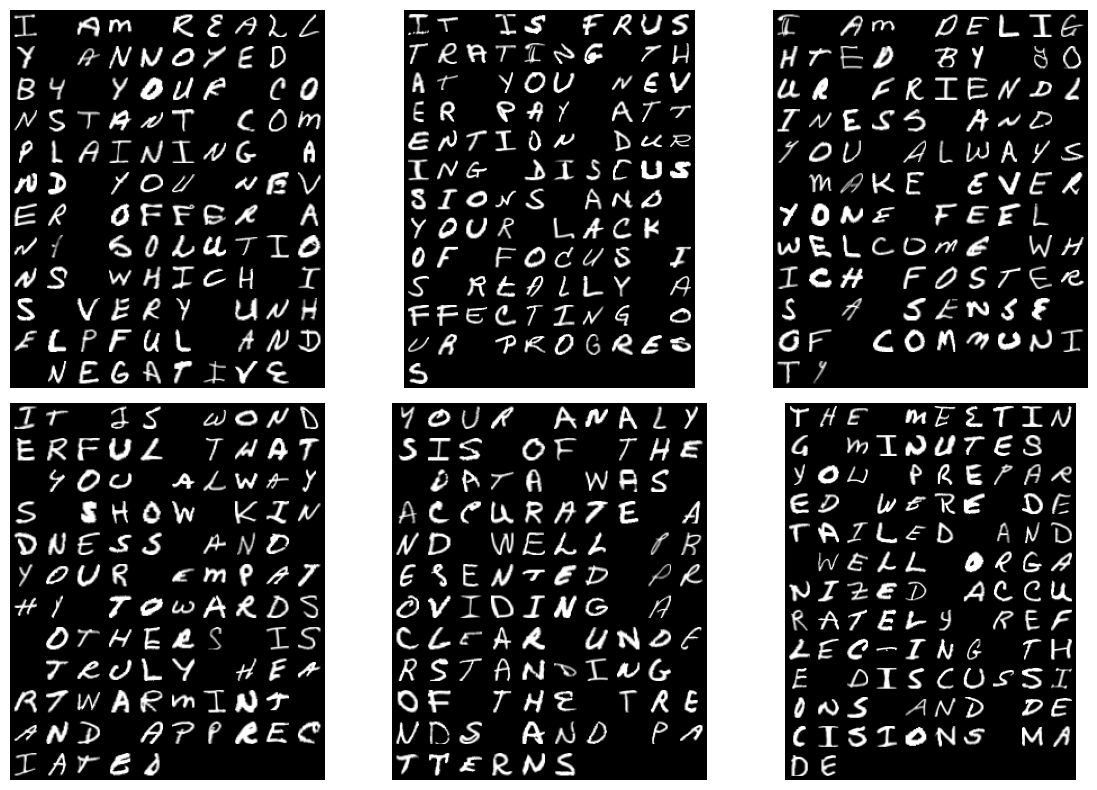

In [70]:
import matplotlib.pyplot as plt
def plot_images_grid(img_list):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns

    for i, ax in enumerate(axes.flat):
        if i < len(img_list):
            ax.imshow(img_list[i])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_images_grid(target_imgs)

Function to cut the images into a grid with each cell having dimensions 28x28

In [71]:
def sent_array_gen(img, k1, k2):
    img1 = np.array(np.mean(img, axis=2))
    sent_img_array = np.empty(((k1 * k2), 28, 28))
    sent_img_array = np.array(sent_img_array)
    k = 0
    for i in range (k1):
        for j in range (k2):
            sent_img_array[k] = img1[int(i * 28):int((i+1) * 28), int(j * 28): int((j+1) * 28)]
            k+=1
    final = np.expand_dims(sent_img_array, axis = 3)
    return final

Fucntion to generate alphabets through each of the image

In [72]:
def gen_alpha(img, prob):
    alpha = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ']
    max = 0
    flag = 0
    for k in range (26):
        if (len(np.unique(img)) == 1):
            flag = 1
    if (flag == 1):
        max = 26
        return alpha[max]
    for k in range (26):
        if (prob[k] > prob[max]):
            max = k
    return alpha[max]

The below cell is a test cell for one of the images

In [73]:
k1, k2, k3 = target_imgs[0].shape
k1 = int(k1 / 28)
k2 = int(k2 / 28)
img = sent_array_gen(target_imgs[0], k1, k2)
y = model.predict(img)
sent = [0]*(k1*k2)
for i in range((k1*k2)):
    sent[i] = gen_alpha(img[i], y[i])
    sent = np.array(sent)
sentences = np.array_str(sent)
print(sentences)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
['I' ' ' 'A' 'M' ' ' 'R' 'E' 'A' 'L' 'L' 'Y' ' ' 'A' 'N' 'N' 'O' 'Y' 'E'
 'D' ' ' 'B' 'Y' ' ' 'Y' 'O' 'U' 'R' ' ' 'C' 'O' 'N' 'S' 'T' 'A' 'N' 'T'
 ' ' 'C' 'O' 'M' 'P' 'L' 'A' 'I' 'N' 'I' 'N' 'G' ' ' 'A' 'N' 'D' ' ' 'Y'
 'O' 'U' ' ' 'N' 'E' 'V' 'E' 'R' ' ' 'O' 'E' 'E' 'E' 'R' ' ' 'A' 'N' 'Y'
 ' ' 'S' 'O' 'L' 'U' 'T' 'I' 'O' 'N' 'S' ' ' 'W' 'H' 'I' 'C' 'H' ' ' 'I'
 'S' ' ' 'V' 'E' 'R' 'Y' ' ' 'U' 'N' 'H' 'E' 'E' 'P' 'F' 'U' 'L' ' ' 'A'
 'N' 'D' ' ' 'N' 'E' 'G' 'A' 'T' 'I' 'V' 'E' ' ']


Function to generate sentences from the predictions

In [74]:
def sent_gen(target_imgs):
    sentences = ['0']*6
    for j in range(6):
        k1, k2, k3 = target_imgs[j].shape
        k1 = int(k1 / 28)
        k2 = int(k2 / 28)
        img = sent_array_gen(target_imgs[j], k1, k2)
        y = model.predict(img)
        sent = [0]*(k1*k2)
        for i in range((k1*k2)):
            sent[i] = gen_alpha(img[i], y[i])
            sent = np.array(sent)
        str = ''
        for k in range (len(sent)):
            str = str + sent[k]
        sentences[j] = str
    return sentences

In [75]:
sentences = sent_gen(target_imgs)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [76]:
sentences[4]

'YOUR ANALYSIS OF THE ODTA WAS ACCURATE AND WELL PREBENTED PROVIDING A CLEAR UNOERSTANDING OF THZ TRENDS AND PATTERNS    '

In [77]:
sentiment_analysis_dataset = pd.read_csv(r"C:\Users\tanay\OneDrive\Documents\Work\Epoch\CNN + NLP (Task 2)\sentiment_analysis_dataset.csv")

In [78]:
df = sentiment_analysis_dataset

In [79]:
df.head()

,line,sentiment
0,I AM REALLY FRUSTRATED BECAUSE YOU CONSTANTLY ...,Angry
1,IT MAKES ME UPSET THAT YOU NEVER TAKE RESPONSI...,Angry
2,I CANNOT BELIEVE YOU MISSED ANOTHER DEADLINE A...,Angry
3,IT ANNOYS ME WHEN YOU INTERRUPT DURING MEETING...,Angry
4,I AM TIRED OF YOUR EXCUSES EVERY TIME SOMETHIN...,Angry


In [80]:
import matplotlib as plt

In [81]:
test_labels = pd.read_csv(r"C:\Users\tanay\OneDrive\Documents\Work\Epoch\CNN + NLP (Task 2)\target_labels.csv")

In [82]:
test_labels = test_labels.drop(['file'], axis = 1)

In [83]:
test_labels.head

<bound method NDFrame.head of   sentiment
0     Angry
1     Angry
2     Happy
3     Happy
4   Neutral
5   Neutral>

In [84]:
test_labels.shape

(6, 1)

In [85]:
sentences = pd.DataFrame(sentences, columns=['line'])
sentences.head()

,line
0,I AM REALLY ANNOYED BY YOUR CONSTANT COMPLAINI...
1,JT IS FRUSTRATING THAT YOU NEVER PAY ATTENTION...
2,I AM DELIGHTEO BY YOUR FRIENDLINESB AND YOU AL...
3,IT IS WONDERFUL THAT YOU ALWAYS SHOW KINDNESS ...
4,YOUR ANALYSIS OF THE ODTA WAS ACCURATE AND WEL...


In [86]:
test_data = pd.concat([sentences, test_labels], axis = 1)
test_data.head()

,line,sentiment
0,I AM REALLY ANNOYED BY YOUR CONSTANT COMPLAINI...,Angry
1,JT IS FRUSTRATING THAT YOU NEVER PAY ATTENTION...,Angry
2,I AM DELIGHTEO BY YOUR FRIENDLINESB AND YOU AL...,Happy
3,IT IS WONDERFUL THAT YOU ALWAYS SHOW KINDNESS ...,Happy
4,YOUR ANALYSIS OF THE ODTA WAS ACCURATE AND WEL...,Neutral


In [87]:
train_data = df
train_data.head()

,line,sentiment
0,I AM REALLY FRUSTRATED BECAUSE YOU CONSTANTLY ...,Angry
1,IT MAKES ME UPSET THAT YOU NEVER TAKE RESPONSI...,Angry
2,I CANNOT BELIEVE YOU MISSED ANOTHER DEADLINE A...,Angry
3,IT ANNOYS ME WHEN YOU INTERRUPT DURING MEETING...,Angry
4,I AM TIRED OF YOUR EXCUSES EVERY TIME SOMETHIN...,Angry


Naive Bayes (Reference: https://www.youtube.com/watch?v=oXZThwEF4r0)

In [88]:
train = train_data
test = test_data

In [89]:
for i in range(30):
    if (train['sentiment'][i] == 'Angry'):
        train['sentiment'][i] = -1
    if (train['sentiment'][i] == 'Happy'):
        train['sentiment'][i] = 1
    if (train['sentiment'][i] == 'Neutral'):
        train['sentiment'][i] = 0
for i in range(6):
    if (test['sentiment'][i] == 'Angry'):
        test['sentiment'][i] = -1
    if (test['sentiment'][i] == 'Happy'):
        test['sentiment'][i] = 1
    if (test['sentiment'][i] == 'Neutral'):
        test['sentiment'][i] = 0

Vectorizing both the train and test data

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score

In [91]:
vectorizer = CountVectorizer(ngram_range=(2,2))

In [92]:
y_train = np.array((train.sentiment).astype(int))

In [93]:
y_test = np.array((test.sentiment).astype(int))

In [94]:
x_train = vectorizer.fit_transform(train.line)
x_test = vectorizer.transform(test.line)

In [95]:
clf = naive_bayes.MultinomialNB()
clf.fit(x_train, y_train)

MultinomialNB()

In [96]:
y_pred = clf.predict(x_test)

In [97]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         2
           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



Simple RNN (Reference: https://www.youtube.com/watch?v=eMPQw7Xbjd0)

In [98]:
train = train_data
test = test_data

In [99]:
for i in range(30):
    if (train['sentiment'][i] == 'Angry'):
        train['sentiment'][i] = -1
    if (train['sentiment'][i] == 'Happy'):
        train['sentiment'][i] = 1
    if (train['sentiment'][i] == 'Neutral'):
        train['sentiment'][i] = 0
for i in range(6):
    if (test['sentiment'][i] == 'Angry'):
        test['sentiment'][i] = -1
    if (test['sentiment'][i] == 'Happy'):
        test['sentiment'][i] = 1
    if (test['sentiment'][i] == 'Neutral'):
        test['sentiment'][i] = 0

In [100]:
test.head()

,line,sentiment
0,I AM REALLY ANNOYED BY YOUR CONSTANT COMPLAINI...,-1
1,JT IS FRUSTRATING THAT YOU NEVER PAY ATTENTION...,-1
2,I AM DELIGHTEO BY YOUR FRIENDLINESB AND YOU AL...,1
3,IT IS WONDERFUL THAT YOU ALWAYS SHOW KINDNESS ...,1
4,YOUR ANALYSIS OF THE ODTA WAS ACCURATE AND WEL...,0


In [101]:
train.head()

,line,sentiment
0,I AM REALLY FRUSTRATED BECAUSE YOU CONSTANTLY ...,-1
1,IT MAKES ME UPSET THAT YOU NEVER TAKE RESPONSI...,-1
2,I CANNOT BELIEVE YOU MISSED ANOTHER DEADLINE A...,-1
3,IT ANNOYS ME WHEN YOU INTERRUPT DURING MEETING...,-1
4,I AM TIRED OF YOUR EXCUSES EVERY TIME SOMETHIN...,-1


In [102]:
x_train = train['line']
y_train = train['sentiment']
x_test = test['line']
y_test = test['sentiment']

In [103]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000, lower=True)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

In [104]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

print(x_train[3, :])

[  6 100  21  40   2 101 102  45   1   2  15 103 104 105  46 106 107   3
 108 109   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [105]:
from tensorflow.keras.utils import to_categorical
num_classes = 3

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_train[0])

(30, 3)
[0. 0. 1.]


In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, SimpleRNN
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences

x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

(30, 100, 1)
(6, 100, 1)


In [107]:
num_classes = 3

def vanilla_rnn():
    model = Sequential()
    
    model.add(SimpleRNN(32, input_shape = (maxlen, 1), return_sequences = False))
    model.add(Dense(4))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.summary()
    
    adam = optimizers.Adam()
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [108]:
from scikeras.wrappers import KerasClassifier

In [109]:
RNN_model = KerasClassifier(build_fn = vanilla_rnn, epochs = 10)
RNN_model.fit(x_train, y_train)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,235 (4.82 KB)

 Trainable params: 1,235 (4.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 1.1304
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3667 - loss: 1.0962
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3667 - loss: 1.0785
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4000 - loss: 1.0595
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5333 - loss: 1.0427
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5667 - loss: 1.0303
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6000 - loss: 1.0167
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5667 - loss: 1.0026
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6333 - loss: 0.9845
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5333 - loss: 0.9620


KerasClassifier(
	model=None
	build_fn=<function vanilla_rnn at 0x00000268EBD00400>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)

In [110]:
y_pred_RNN = RNN_model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [111]:
print(classification_report(y_test, y_pred_RNN))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       1.00      0.50      0.67         2

   micro avg       0.17      0.17      0.17         6
   macro avg       0.33      0.17      0.22         6
weighted avg       0.33      0.17      0.22         6
 samples avg       0.17      0.17      0.17         6

